# Stack-Overflow Annual Developer Survey Analyis


Within this Analysis I analyze what influences Salary within developer jobs. <br>
The goal is to develop a model that could potentially *help employees estimate their worth* and *employers plan their expense* in a market that is sometimes intransparent in regards to salary.

In [37]:
# Import all packages needed
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.tree import DecisionTreeRegressor, plot_tree 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from typing import Optional, List, Union
import shap
import category_encoders as ce



In [38]:
# Load survey schema

schema = pd.read_csv('data/survey_results_schema.csv')
schema.head()

,qid,qname,question,force_resp,type,selector
0,QID2,MainBranch,Which of the following options best describes ...,True,MC,SAVR
1,QID127,Age,What is your age?*,True,MC,SAVR
2,QID296,Employment,Which of the following best describes your cur...,True,MC,MAVR
3,QID308,RemoteWork,Which best describes your current work situation?,False,MC,SAVR
4,QID341,Check,Just checking to make sure you are paying atte...,True,MC,SAVR


In [39]:
# Load data

df_raw = pd.read_csv('data/survey_results_public.csv')
df_raw.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


----------------------------

--------------------

## 1. Exploratory Data Analysis

Check the PDF of the Survey that comes with the data for a detailed understanding of the survey and its questions (i.e. potential features and targets).

#### Check the target = Salary
`ConvertedCompYearly`

In [40]:
df_eda = df_raw.copy()

In [41]:
# some simple descriptive statistics
print(f'Rows without salary information {df_eda.ConvertedCompYearly.isna().sum()}')
df_eda.ConvertedCompYearly.describe()

Rows without salary information 42002


count    2.343500e+04
mean     8.615529e+04
std      1.867570e+05
min      1.000000e+00
25%      3.271200e+04
50%      6.500000e+04
75%      1.079715e+05
max      1.625660e+07
Name: ConvertedCompYearly, dtype: float64

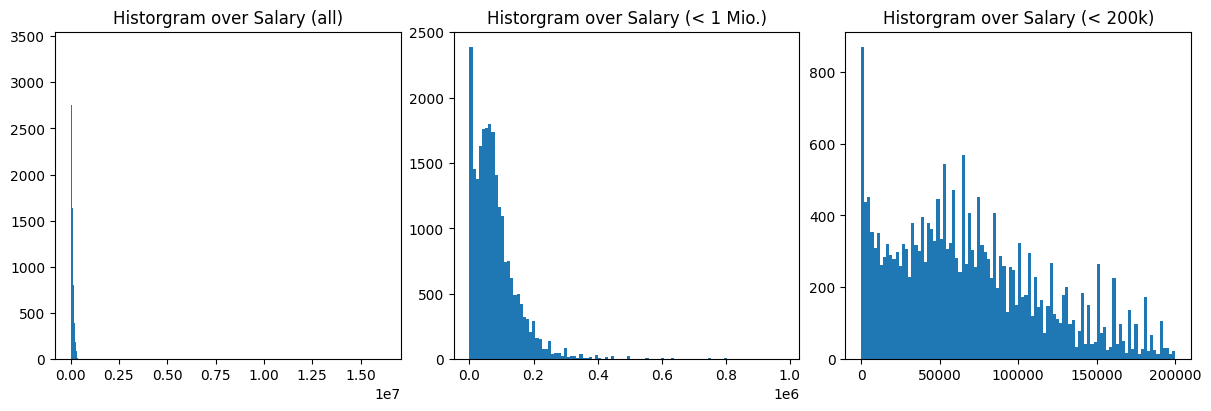

In [42]:
# Check distribution of salary

fig, axs = plt.subplots(1, 3, layout='constrained', figsize=(12, 4))
axs[0].hist(df_eda.ConvertedCompYearly, bins = 1000) 
axs[0].set_title('Historgram over Salary (all)')
axs[1].hist(df_eda.ConvertedCompYearly[df_eda.ConvertedCompYearly < 1000000], bins = 100) 
axs[1].set_title('Historgram over Salary (< 1 Mio.)')
axs[2].hist(df_eda.ConvertedCompYearly[df_eda.ConvertedCompYearly < 200000], bins = 100) 
axs[2].set_title('Historgram over Salary (< 200k)')

plt.show()

*Issues*  to consider:
- Just a little more than 1/3 of the participants gave a salary.
- Salary extremly skewed (potentially influential outliers)
- A lot of participants gave unrealistically small salary (~ 0)


In [43]:
# Exploring Features only on rows with salary!
df_eda = df_eda[df_eda.ConvertedCompYearly.notna()]
df_eda.shape

(23435, 114)

In [44]:
print(df_eda[df_eda.ConvertedCompYearly < 500].ConvertedCompYearly.value_counts())
# salary < 500$ seems unrealistic for a full time job even in low income countries --> exclude
# extremly high salaries might have high impect and be influential in leafs
df_eda = df_eda[(df_eda['ConvertedCompYearly'] > 500) & (df_eda['ConvertedCompYearly'] < 200000)]
df_eda.shape

ConvertedCompYearly
1.0      16
494.0     6
148.0     6
3.0       5
296.0     5
         ..
485.0     1
452.0     1
319.0     1
271.0     1
63.0      1
Name: count, Length: 191, dtype: int64


(21586, 114)

------------------------------------------------------------------------------------------------------------------------------

#### Potential features examination

To keep the model relatively simple, interpretable and usable for prediction features will only include the first two sections of the survey (1. Basic Information & 2 - Education + Work + Career.) <br>
Additionally questions `BuyNewTool`, `BuildvsBuy`, `TechEndorse` will be excluded for two main reasons:
1. No logical reason why they should influence salary
2. And more importantly, not really applicable when trying to predict an appropriate salary

`Currency` will be excluded as Salary in target is converted already and besides conversion, currency mostly represents duplicate information with country.

`LearnCodeOnline` will be excluded as it is clearly secondary information to `LearnCode`.

`TechDoc` will be excluded. This might indirectly represent a devs abilities or style of work but seems like in theory it should not *directly* influence salary.


In [45]:
# make sure to only include those that passed the check of attention in survey
# --> only those who pass can continue the survey so 100% pass in data
df_eda.Check.describe()

count      21586
unique         1
top       Apples
freq       21586
Name: Check, dtype: object

##### `MainBranch` & `Emplyoment`
Technically we only care about those who work as some sort of dev professionally as we want to determine what influences salary of a dev. For comparibility we stick to full time emplyoment.

In [46]:
# filter to keep only those working as some sort of dev professionally and being employed full time
df_eda = df_eda[
    (df_eda['MainBranch'] == "I am a developer by profession") &
    (df_eda['Employment'].str.contains("Employed, full-time", na=False))
]

df_eda.shape

(17340, 114)

In [47]:
# preselection of features
df_eda = df_eda[['Age', 'RemoteWork', 'CodingActivities', 'EdLevel', 'LearnCode', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize',
       'PurchaseInfluence', 'Country', 'ConvertedCompYearly']]

df_eda.shape

(17340, 12)

In [48]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17340 entries, 72 to 41185
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  17340 non-null  object 
 1   RemoteWork           17338 non-null  object 
 2   CodingActivities     17337 non-null  object 
 3   EdLevel              17340 non-null  object 
 4   LearnCode            17313 non-null  object 
 5   YearsCode            17305 non-null  object 
 6   YearsCodePro         17293 non-null  object 
 7   DevType              17318 non-null  object 
 8   OrgSize              17322 non-null  object 
 9   PurchaseInfluence    17313 non-null  object 
 10  Country              17340 non-null  object 
 11  ConvertedCompYearly  17340 non-null  float64
dtypes: float64(1), object(11)
memory usage: 1.7+ MB


##### `YearsCode` & `YearsCodePro`

Apart from our target all columns (features) are of datatype object. <br>
`YearsCode` & `YearsCodePro` could technically be numerical. So lets check them:

In [49]:
df_eda.YearsCode.unique()
df_eda.YearsCode.value_counts()

YearsCode
10                    1621
8                     1172
7                     1030
6                     1010
15                     981
12                     921
5                      859
20                     814
9                      802
14                     704
4                      630
11                     615
13                     557
16                     490
25                     488
18                     446
17                     393
3                      372
30                     370
24                     272
22                     261
19                     212
40                     211
23                     190
21                     184
26                     175
2                      171
35                     168
27                     139
28                     135
32                      91
38                      83
29                      81
34                      80
42                      66
33                      64
45                

In [50]:
df_eda.YearsCodePro.value_counts()

YearsCodePro
3                   1555
2                   1379
5                   1377
4                   1254
6                   1174
10                  1116
8                   1033
7                    992
12                   662
1                    661
9                    610
15                   526
11                   513
13                   414
20                   400
Less than 1 year     386
14                   380
16                   318
17                   292
18                   272
25                   268
19                   182
24                   160
23                   153
22                   149
30                   140
26                   138
28                   109
21                   107
27                    98
35                    61
29                    52
32                    52
40                    45
34                    40
38                    36
33                    32
31                    31
37                    26
36          

We can clearly see that the format of the question allowed for or explictly offered answers that cannot be converted to float or integer. <br>
These values make up only a fraction of the dataset but represent edge cases (<1 year and > 50 years). 

We have the option to exclude these values and convert the rest to integer or replace these values with an adequate integer. <br>
To ensure that the model applies to people with very little or very much coding experience as well I am going to keep the edge cases and convert them to the next integer (i.e. < 1year &rarr; 0 and >50 &rarr; 51). <br>
Furthermore I am going to treat years as continious variables.

In [51]:
# replace values

df_eda.replace(
    {'More than 50 years': '51', 'Less than 1 year': '0'}, inplace=True
)

# convert to int

# Convert the two columns to integers
df_eda['YearsCode'] = pd.to_numeric(df_eda['YearsCode'], errors='coerce').fillna(0).astype(int)
df_eda['YearsCodePro'] = pd.to_numeric(df_eda['YearsCodePro'], errors='coerce').fillna(0).astype(int)

# check if it worked
df_eda.info()

print(df_eda.YearsCode.value_counts())
 
print(df_eda.YearsCodePro.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 17340 entries, 72 to 41185
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  17340 non-null  object 
 1   RemoteWork           17338 non-null  object 
 2   CodingActivities     17337 non-null  object 
 3   EdLevel              17340 non-null  object 
 4   LearnCode            17313 non-null  object 
 5   YearsCode            17340 non-null  int64  
 6   YearsCodePro         17340 non-null  int64  
 7   DevType              17318 non-null  object 
 8   OrgSize              17322 non-null  object 
 9   PurchaseInfluence    17313 non-null  object 
 10  Country              17340 non-null  object 
 11  ConvertedCompYearly  17340 non-null  float64
dtypes: float64(1), int64(2), object(9)
memory usage: 1.7+ MB
YearsCode
10    1621
8     1172
7     1030
6     1010
15     981
12     921
5      859
20     814
9      802
14     704
4      630
11

array([[<Axes: xlabel='YearsCode', ylabel='YearsCode'>,
        <Axes: xlabel='YearsCodePro', ylabel='YearsCode'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='YearsCode'>],
       [<Axes: xlabel='YearsCode', ylabel='YearsCodePro'>,
        <Axes: xlabel='YearsCodePro', ylabel='YearsCodePro'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='YearsCodePro'>],
       [<Axes: xlabel='YearsCode', ylabel='ConvertedCompYearly'>,
        <Axes: xlabel='YearsCodePro', ylabel='ConvertedCompYearly'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='ConvertedCompYearly'>]],
      dtype=object)

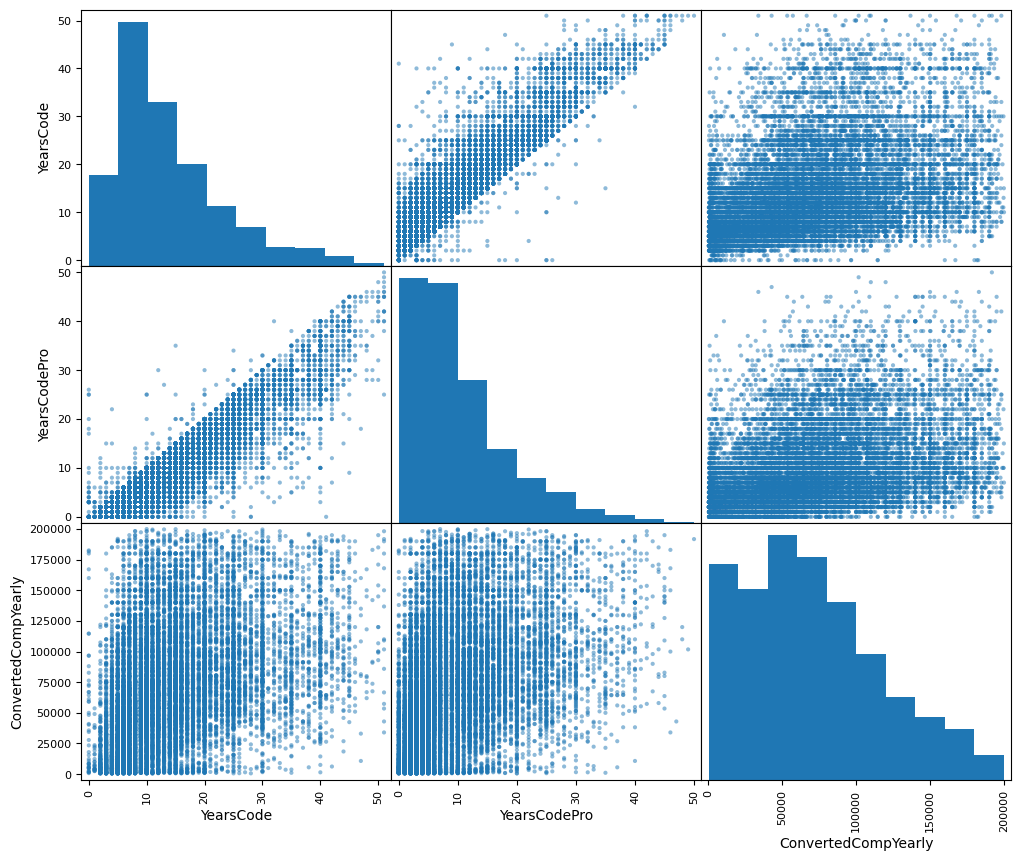

In [52]:
scatter_matrix(df_eda[['YearsCode', 'YearsCodePro', 'ConvertedCompYearly']], figsize=(12, 10))

We can see that both `YearsCode` and `YearsCodePro`have a right skewed distribution. <br>

These two variables are clearly correlated &rarr; potentially colinearity <br>

No clear relationship visible between `YearsCode` and `YearsCodePro` and our target. But might at least partially be obscured by the outliers <br>

In [53]:
# check categorical features for imbalance
cat_features = ['Age', 'RemoteWork', 'CodingActivities', 'EdLevel', 'LearnCode',
       'DevType', 'OrgSize', 'PurchaseInfluence', 'Country', 'ConvertedCompYearly']

for f in cat_features:
    print(f'{f}:')
    
    print(df_eda[f].value_counts())

Age:
Age
25-34 years old       8329
35-44 years old       4480
18-24 years old       2466
45-54 years old       1467
55-64 years old        516
65 years or older       62
Under 18 years old      14
Prefer not to say        6
Name: count, dtype: int64
RemoteWork:
RemoteWork
Hybrid (some remote, some in-person)    7591
Remote                                  6737
In-person                               3010
Name: count, dtype: int64
CodingActivities:
CodingActivities
Hobby                                                                                                                                                                                   3434
Hobby;Professional development or self-paced learning from online courses                                                                                                               2347
I don’t code outside of work                                                                                                                            

##### `CodingActivities`

In [54]:
# For simplicity and essentially interpretability of the model we will only distinguish between those that code outside of work and those who don't
# The number pf possible combination of coding activities outside of work would make the model very hard to interpret
# print(df_eda['CodingActivities'].unique())

# 0 = dont code outside of work
df_eda['CodingOutsideOfWork'] = 1
df_eda.loc[df_eda['CodingActivities'].str.contains("I don’t code outside of work", na=False), 'CodingOutsideOfWork'] = 0
df_eda.drop(['CodingActivities'], axis=1, inplace=True)
df_eda.CodingOutsideOfWork.value_counts()

CodingOutsideOfWork
1    15224
0     2116
Name: count, dtype: int64

##### `LearnCode`

In [55]:
# For the same reason (interpretability) we will only include one dummy / boolean for each learning type instead of including each possible combination of learning experiences as dummies

df_eda['LC_PhysicalMedia'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('Books / Physical media', na=False), 'LC_PhysicalMedia'] = 1
print(df_eda.LC_PhysicalMedia.value_counts())

df_eda['LC_Bootcamp'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('Coding Bootcamp', na=False), 'LC_Bootcamp'] = 1
print(df_eda.LC_Bootcamp.value_counts())


df_eda['LC_Colleague'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('Colleague', na=False), 'LC_Colleague'] = 1
print(df_eda.LC_Colleague.value_counts())


df_eda['LC_FriendFamily'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('Friend or family member', na=False), 'LC_FriendFamily'] = 1
print(df_eda.LC_FriendFamily.value_counts())


df_eda['LC_Online'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('Online Courses or Certification', na=False), 'LC_Online'] = 1
print(df_eda.LC_Online.value_counts())


df_eda['LC_Job'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('On the job training', na=False), 'LC_Job'] = 1
print(df_eda.LC_Job.value_counts())


df_eda['LC_OnlineOther'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('Other online resources', na=False), 'LC_OnlineOther'] = 1
print(df_eda.LC_OnlineOther.value_counts())


df_eda['LC_School'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('School', na=False), 'LC_School'] = 1
print(df_eda.LC_School.value_counts())

df_eda.drop(['LearnCode'], axis=1, inplace=True)



LC_PhysicalMedia
1    8895
0    8445
Name: count, dtype: int64
LC_Bootcamp
0    15557
1     1783
Name: count, dtype: int64
LC_Colleague
0    12499
1     4841
Name: count, dtype: int64
LC_FriendFamily
0    15678
1     1662
Name: count, dtype: int64
LC_Online
1    9034
0    8306
Name: count, dtype: int64
LC_Job
1    9186
0    8154
Name: count, dtype: int64
LC_OnlineOther
1    14320
0     3020
Name: count, dtype: int64
LC_School
1    8802
0    8538
Name: count, dtype: int64


##### `Age`

*Unfortunately* age is available only in categories. we can treat it as ordinal and encode with `OrdinalEncoder`to keep as much information as possible. <br>

*'I prefer no to say'* will be treated as missing value.

In [56]:
df_eda.replace(
    {'Prefer not to say': np.nan}, inplace=True
)
df_eda.Age.unique()

array(['18-24 years old', '35-44 years old', '25-34 years old',
       '45-54 years old', '55-64 years old', '65 years or older',
       'Under 18 years old', nan], dtype=object)

##### `Countries`


In [57]:
df_eda['Country'].value_counts()

Country
United States of America                                3013
Germany                                                 1463
Ukraine                                                 1147
United Kingdom of Great Britain and Northern Ireland    1083
India                                                    886
                                                        ... 
Lesotho                                                    1
Burundi                                                    1
Botswana                                                   1
Mali                                                       1
Congo, Republic of the...                                  1
Name: count, Length: 156, dtype: int64

As a first remedy for the large number of countries with sparse data we will use `frequency encoding`, making the **Assumption**  the frequency of the Country in this data is not due to some sampling bias but rather a reflection of economic factors. 

##### `RemoteWork`

Could be considered ordinal &rarr; `Ordinal Encoding`

In [58]:
df_eda['RemoteWork'].value_counts()

RemoteWork
Hybrid (some remote, some in-person)    7591
Remote                                  6737
In-person                               3010
Name: count, dtype: int64

##### `EdLevel`

While there is some order of education level this does not hold true for all categories (different types rather than different level), therefore we ordinal encoding is not an option and we have to stick to `one-hot encoding`


In [59]:
df_eda['EdLevel'].value_counts()

EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          8038
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       5089
Some college/university study without earning a degree                                1948
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     789
Professional degree (JD, MD, Ph.D, Ed.D, etc.)                                         651
Associate degree (A.A., A.S., etc.)                                                    577
Something else                                                                         166
Primary/elementary school                                                               82
Name: count, dtype: int64

##### `DevType`

'Other' will be treated as as other together with those jobs with less than 30 occurences. 30 is somewhat arbitrary and definely up for debate.

In [60]:
"""
counts = df_eda['DevType'].value_counts()

df_eda['DT'] = df_eda['DevType'].apply(
    lambda x: x if counts.get(x, 0) >= 30 and 'Other (please specify):' not in x else 'Other'
).str.replace(' ', '_', regex=False)

df_eda = pd.get_dummies(df_eda, columns=['DT'], dtype=float).drop(columns=['DevType'])
df_eda.head()

"""

"\ncounts = df_eda['DevType'].value_counts()\n\ndf_eda['DT'] = df_eda['DevType'].apply(\n    lambda x: x if counts.get(x, 0) >= 30 and 'Other (please specify):' not in x else 'Other'\n).str.replace(' ', '_', regex=False)\n\ndf_eda = pd.get_dummies(df_eda, columns=['DT'], dtype=float).drop(columns=['DevType'])\ndf_eda.head()\n\n"

##### `OrgSize`

OrgSize can be considered ordinal, so we'll use OrdinalEncoder. <br>
*'I don't know'* will be treated as missing values. <br>
*'Just me - I am a freelancer, sole proprietor, etc.'* will be excluded. While one could argue that it is the smallest OrgSize, it is also indicative of a potentially very different type of organization. Also freelancing and self-employment does not fit into the theme of traditional salary decisions and negotiation. <br>

In [61]:
# remove freelancing and self-employment
df_eda = df_eda[
    df_eda['OrgSize'] != "Just me - I am a freelancer, sole proprietor, etc."
]

df_eda.replace(
    {'I don’t know': np.nan}, inplace=True
)

##### `PurchaseInfluence`

`PurchaseInfluence` can be considered ordinal as well, so well use ordinal encoder once again.


Attention to imbalances:
- age (young and old underepresented)
- education (very high and low level of education underrepresented)
- large minority codes outside of work
- imbalances in learning resources
- imbalance in jobs

**For now i am going to keep these imbalances in mind but won't try to rectify them. Most of these 'imbalances' are akin to the usual normal distribution in a large sample (e.g.) age and higher accuracy within these ranges with higher density is not necessarily bad if the (target) population shows similar distribution tendencies.**

In [62]:
nans= df_eda.isna().sum()
nans[nans>0]

Age                    6
RemoteWork             2
DevType               22
OrgSize              248
PurchaseInfluence     26
dtype: int64

#### Missing values

With the small number of missing values (relative to sample size) i could remove rows with missing values or impute. Both should have little influence. <br>
I decided for a simple imputation. 

## Model development

The first idea was to go with a **Decision Tree** for regression of the salary. <br>
This is because most selected features are unlikely (or guarenteed not to have) to have a linear relationship with the target. Decision trees tend to work well with non linear relationships. <br>

Furthermore, I am looking for a model that allows for clear interpretation of the factors influencing the expected salary. <br>
Again Decision Trees are a good choice in that regard (if the number of branches is kept relatively small). 

**But** decision trees, especially shallow ones, can really struggle in high-dimensional spaces as we have here after dummy encoding. Therefore I am going to use *Random Forest*. This has the added benefit of little less sucscpetiblity to outliers.

Not using standardization as all variables are categorical apart from `YearsCode` & `YearsCodePro` which are very similar in scale.

In [63]:
df_eda.columns

Index(['Age', 'RemoteWork', 'EdLevel', 'YearsCode', 'YearsCodePro', 'DevType',
       'OrgSize', 'PurchaseInfluence', 'Country', 'ConvertedCompYearly',
       'CodingOutsideOfWork', 'LC_PhysicalMedia', 'LC_Bootcamp',
       'LC_Colleague', 'LC_FriendFamily', 'LC_Online', 'LC_Job',
       'LC_OnlineOther', 'LC_School'],
      dtype='object')

In [64]:
ordinal_features = ['RemoteWork', 'Age', 'OrgSize', 'PurchaseInfluence']
to_target_features = ['Country', 'DevType']
dummies = [column for column in df_eda if column.startswith('LC')] 

# 🏷️ Define categories (orders) for ordinal columns
categories_dict = {
    'RemoteWork': ['In-person','Hybrid (some remote, some in-person)', 'Remote', np.nan],
    'Age': ['Under 18 years old', '18-24 years old', '25-34 years old', '35-44 years old',
              '45-54 years old', '55-64 years old', '65 years or older', np.nan],
    'OrgSize': ['2 to 9 employees', '10 to 19 employees', '20 to 99 employees', '100 to 499 employees', 
                '500 to 999 employees', '1,000 to 4,999 employees', '5,000 to 9,999 employees', '10,000 or more employees', np.nan],
    'PurchaseInfluence': ['I have little or no influence', 'I have some influence', 'I have a great deal of influence', np.nan]
}


In [65]:
# Preprocessing

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """
    Frequency encoder for categorical features.

    Replaces each category with its frequency (or count) in the training set.
    Compatible with scikit-learn pipelines.

    Parameters:
    ----------
    columns : Optional[List[str]]
        List of column names to encode. If None, all object-type columns are encoded.
    normalize : bool
        If True, use relative frequencies; if False, use raw counts.
    prefix : str
        Prefix to add to the new encoded column names.
    drop : bool
        If True, drop the original categorical columns after encoding.
    """

    def __init__(
        self,
        columns: Optional[List[str]] = None,
        normalize: bool = True,
        prefix: str = "fq_",
        drop: bool = True,
    ):
        self.columns = columns
        self.normalize = normalize
        self.prefix = prefix
        self.drop = drop
        self.freq_maps_: dict[str, pd.Series] = {}

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "FrequencyEncoder":
        """
        Learn frequency maps for specified columns.

        Parameters:
        ----------
        X : pd.DataFrame
            The input DataFrame.
        y : pd.Series or None
            Ignored (for pipeline compatibility).

        Returns:
        -------
        self : FrequencyEncoder
            The fitted transformer.
        """
        # convert to data frame (Column Transformer turns X into ndarray)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.columns)
        # Auto-detect columns if none provided
        if self.columns is None:
            self.columns = X.select_dtypes(include="object").columns.tolist()


        # Build frequency/count maps
        for col in self.columns:
            if col not in X.columns:
                raise ValueError(f"Column '{col}' not found in input DataFrame.")
            self.freq_maps_[col] = X[col].value_counts(normalize=self.normalize)

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Apply frequency encoding to the specified columns.

        Parameters:
        ----------
        X : pd.DataFrame
            The input DataFrame.

        Returns:
        -------
        X_transformed : pd.DataFrame
            The transformed DataFrame with encoded features.
        """
        X = X.copy() 
        # convert to data frame (Column Transformer turns X into ndarray)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.columns)
            
        for col in self.columns:
            encoded_col = f"{self.prefix}{col}"
            freq_map = self.freq_maps_.get(col, pd.Series(dtype=float))
            X[encoded_col] = X[col].map(freq_map).fillna(0.0)

        if self.drop:
            X.drop(columns=self.columns, inplace=True)

        return X
    





In [66]:
X = df_eda.drop(columns=['ConvertedCompYearly'])
y = df_eda['ConvertedCompYearly']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print(
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape
)


"""
frequency_encode_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('freq_encoder', FrequencyEncoder(columns=frequency_features))
])
"""

target_encode_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', ce.TargetEncoder())
])


ordinal_encode_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1,
                                categories=[categories_dict[cat] for cat in ordinal_features])),
    ('scaler', StandardScaler())  

])

dummy_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Impute missing values (median less affected by outliers)
        ('scaler', StandardScaler())  
])

# tbd: clip
 
preprocessor = ColumnTransformer([
    (
        'ordinal', ordinal_encode_pipeline, ordinal_features
    ),
    (
        'to_target', target_encode_pipeline, to_target_features
    ),
    (
        'dummy', dummy_pipeline, dummies
    ),
    (
        'numeric', numeric_pipeline, ['YearsCode', 'YearsCodePro']
    )
]
)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(
        n_estimators=200,       # number of trees
        max_depth=20,           # not too deep
        min_samples_split=100,   # prevents overfitting
        random_state=1
        )
    ) # start with high level of depth but still interpretable
])

(13792, 18) (3448, 18) (13792,) (3448,)


In [67]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['In-person',
                                                                                               'Hybrid '
                                                                                               '(some '
                                                                                               'remote, '
                                                                                               'some '
                                                                                               'in-person)',
                                                                                               'Remote',
                                                                                               nan],
                                                                                              ['Under '
                                                                                               '18 '
                                                                                               'years '
                                                                                               'old',
                                                                                               '18-24 '
                                                                                               'years '
                                                                                               'old',
                                                                                               '25-34 '
                                                                                               'years '
                                                                                               'old',
                                                                                               '35-44 '
                                                                                               'years '
                                                                                               'old',
                                                                                               '45-54 '
                                                                                               'years...
                                                  ['LC_PhysicalMedia',
                                                   'LC_Bootcamp',
                                                   'LC_Colleague',
                                                   'LC_FriendFamily',
                                                   'LC_Online', 'LC_Job',
                                                   'LC_OnlineOther',
                                                   'LC_School']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YearsCode',
                                                   'YearsCodePro'])])),
                ('rf',
                 RandomForestRegressor(max_depth=20, min_samples_split=100,
                                       n_estimators=200, random_state=1))])

In [68]:
yhat_train = pipeline.predict(X_train)
yhat_test = pipeline.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))

print(rmse_train, rmse_test)

25797.49509788794 26286.026308396402


In [ ]:
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('lr', LinearRegression())
])
pipeline.fit(X_train, y_train)

yhat_train = pipeline.predict(X_train)
yhat_test = pipeline.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))

print(rmse_train, rmse_test)

In [33]:
def get_feature_names_from_column_transformer(ct):
    output_features = []

    for name, transformer, columns in ct.transformers_:
        if transformer == 'drop' or transformer == 'passthrough':
            continue

        # If it's a pipeline, get the last step
        if hasattr(transformer, 'named_steps'):
            transformer = transformer.named_steps[next(reversed(transformer.named_steps))]

        if hasattr(transformer, 'get_feature_names_out'):
            try:
                names = transformer.get_feature_names_out(columns)
            except:
                names = columns
        else:
            names = columns

        output_features.extend(names)

    return output_features


In [35]:
model = pipeline.named_steps['rf']  # access the fitted model from the pipeline
importances = model.feature_importances_
preprocessor = pipeline.named_steps['preprocessing']
feature_names = get_feature_names_from_column_transformer(preprocessor)

for (i, f) in zip(importances, feature_names):
    print(f, i)

RemoteWork 0.011428168553197154
Age 0.004532276617504639
OrgSize 0.037851287409103554
PurchaseInfluence 0.003928507462749195
0 0.7212667294377585
1 0.04207385329525595
LC_PhysicalMedia 0.0007048790170941531
LC_Bootcamp 0.0007180444547237089
LC_Colleague 0.0010040851104791317
LC_FriendFamily 0.0011413321357511973
LC_Online 0.004984585033270354
LC_Job 0.0019392296579309454
LC_OnlineOther 0.0012842846019482336
LC_School 0.0005407994908977673
YearsCode 0.016002822411956247
YearsCodePro 0.15059911531037928


In [ ]:
explainer = shap.TreeExplainer(model)
# Calculate SHAP values
shap_values = explainer.shap_values(X_test)
# Now you can visualize or analyze the SHAP values for the test set
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

In [36]:
explainer = shap.TreeExplainer(model)
# Calculate SHAP values
shap_values = explainer.shap_values(preprocessor.transform(X_test))
# Now you can visualize or analyze the SHAP values for the test set
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], preprocessor.transform(X_test)[0])